In [1]:
# Add root directory to path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('..'),
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

# Imports
from electronTransportCode.SimOptions import PointSourceSimulation
from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.MCParticleTracer import AnalogParticleTracer
from electronTransportCode.MCEstimator import FluenceEstimator, DoseEstimator, TrackEndEstimator
from electronTransportCode.ParticleModel import PointSourceParticle
from electronTransportCode.Material import unitDensityMaterial
%matplotlib widget

### Set up all objects
Either do simulation, or load objects from data file

In [2]:
SEED: int = 4  # Random number generator seed
SIM: bool = False

if SIM:
    NB_PARTICLES = 100000
    
    # Set up initial conditions
    eSource: float = 1.0

    # Set up simulation domain
    xmin = -1.0; xmax = 1.0; xbins = 100
    ymin = -1.5; ymax = 1.5; ybins = 100
    simDomain = SimulationDomain(xmin, xmax, ymin, ymax, xbins, ybins, material=unitDensityMaterial)
    pointSourceSim = PointSourceSimulation(minEnergy=0.0, rngSeed=SEED, eSource=eSource)

    # Set up dose estimator
    Ebins = 100
    fluenceEstimator = FluenceEstimator(simDomain=simDomain, Emin=0.0, Emax=eSource, Ebins=Ebins)
    doseEstimator = DoseEstimator(simDomain)
    trackEndEstimator = TrackEndEstimator(simDomain, NB_PARTICLES)

    # Set up particle
    particle = PointSourceParticle(generator=SEED)  # rng is later overridden by simulation object 

    # Set up particle tracer
    particleTracer = AnalogParticleTracer(particle=particle, simOptions=pointSourceSim, simDomain=simDomain)
    
    
    particleTracer(nbParticles=NB_PARTICLES, estimators=(fluenceEstimator, doseEstimator, trackEndEstimator))
    print(f'Average amount of events: {particleTracer.averageNbCollisions}')
else:
    with open('data/particleTracer.pkl', 'rb') as file:
        particleTracer = pickle.load(file)
        
    with open('data/fluenceEstimator.pkl', 'rb') as file:
        fluenceEstimator = pickle.load(file)
        
    with open('data/doseEstimator.pkl', 'rb') as file:
        doseEstimator = pickle.load(file)
        
    with open('data/trackEndEstimator.pkl', 'rb') as file:
        trackEndEstimator = pickle.load(file)

    particle = particleTracer.particle
    simDomain = particleTracer.simDomain
    pointSourceSim = particleTracer.simOptions

    eSource= pointSourceSim.eSource
    xmin = simDomain.xmin
    xmax = simDomain.xmax
    ymin = simDomain.ymin
    ymax = simDomain.ymax
    xbins = simDomain.xbins
    ybins = simDomain.ybins
    Ebins = fluenceEstimator.Ebins

Compute exact solution at t = 1

In [3]:
# # Compute exact solution at E = 0 (t = 1)
import enum
import exactSolution
solRes = 201

rs = np.linspace(0.001, 1, solRes)  # Discontuity from the source at the origin
res = np.zeros_like(rs)
for index, r in enumerate(rs):
    res[index] = exactSolution.pointSourceSolution(r, 0.0, eSource)
    
# Normalise
res = res/np.trapz(y=res, x=rs)

Plot 2D particle distribution

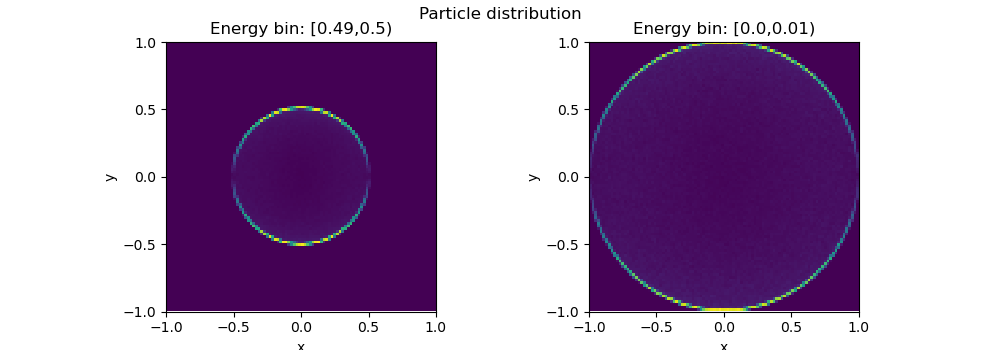

In [4]:
# Plot energy deposition
ebin2Index = 0
ebin1Index = int((Ebins-1)/2)
finalFluence = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin2Index, :], (xbins, xbins)))
initFluence = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin1Index, :], (xbins, xbins)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))
fig.suptitle('Particle distribution')

roundDigits = 3
# Initial particle distribution
bin1left = np.round(fluenceEstimator.Erange[ebin1Index], roundDigits)
bin1right = np.round(fluenceEstimator.Erange[ebin1Index+1], roundDigits)
ax1.set_title(f'Energy bin: [{bin1left},{bin1right})')
ax1.matshow(initFluence, extent=[xmin, xmax, ymin, ymax])
ax1.set_xticks(np.linspace(xmin, xmax, 5))
ax1.set_yticks(np.linspace(xmin, xmax, 5))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# End particle distribution
bin2left = np.round(fluenceEstimator.Erange[ebin2Index], roundDigits)
bin2right = np.round(fluenceEstimator.Erange[ebin2Index+1], roundDigits)
ax2.matshow(finalFluence, extent=[xmin, xmax, ymin, ymax])
ax2.set_title(f'Energy bin: [{bin2left},{bin2right})')
ax2.set_xticks(np.linspace(xmin, xmax, 5))
ax2.set_yticks(np.linspace(xmin, xmax, 5))
ax2.xaxis.tick_bottom()
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.show()

From left to right: particle distribution $\psi(r, \mu, t)$ from simulation at t = 0.505 and t = 0.995. The initial direction $\mu$ is chosen uniformly in [-1, 1], therefore initially, particles move in the vertical direction.

0.6090280000000006
0.3909719999999995


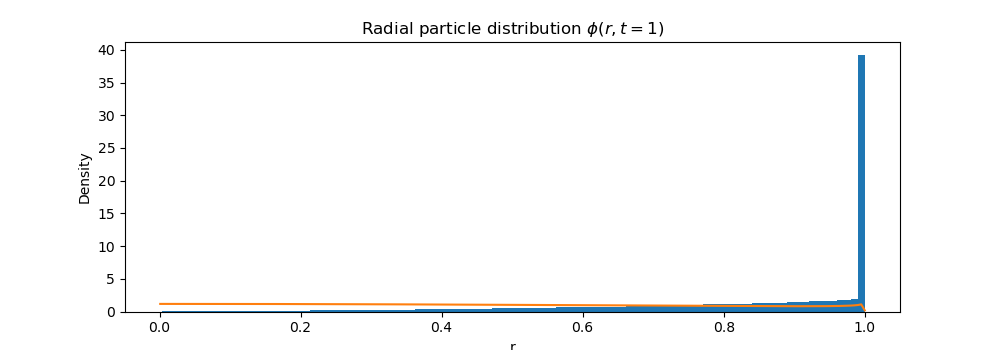

In [5]:
# Radial Particle distribution at t = 1.0 
fig, ax1 = plt.subplots(figsize=(10, 3.5))
radialDensity = trackEndEstimator.scoreMatrix
binVal, binEdge, _ = ax1.hist(radialDensity, bins=100, density=True, label='From simulation')
ax1.set_xlabel('r')
ax1.set_ylabel('Density')
ax1.set_title('Radial particle distribution $\phi(r, t=1)$')
ax1.plot(rs, res, label='Exact radial density')

print(sum(binVal[0:-1])/sum(binVal))  # Theoretical 
print(binVal[-1]/sum(binVal))

The scattering rate is 1, particles move at velocity 1 and they are transported 1 second. From the exponential distribution we thus know that 63.2% of particles will collide within 1 distance unit. The other 36.8 percent of particles will not collide and are thus expected to be at the edge of the domain after 1 second. Particles that have collided scattering with an average angle of 90 degrees and thus cannot reach the border before t = 1.

From the simulation we have that 61% of particles, at time = 1, lie in the domain [0, 0.99]. The remaining 39% lie in the final bin. The blue bars (simulation) is intuitively correct. The orange line makes no sense. 

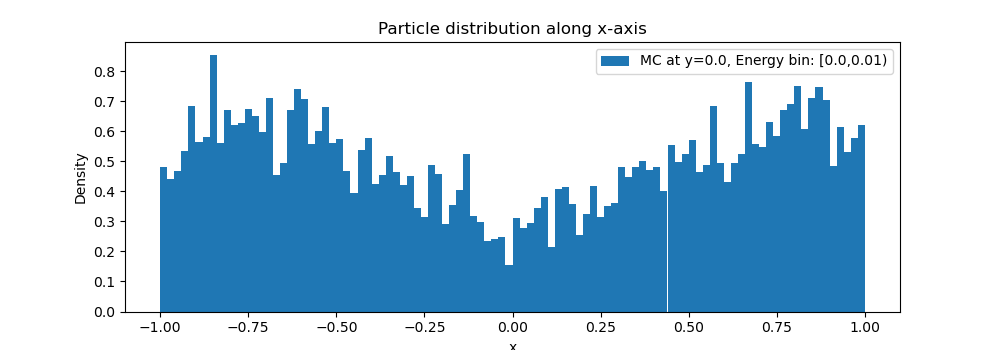

In [6]:
 # End particle distribution along x-axis
ybin1Index = int((ybins)/2)

ybin1down = np.round(simDomain.yrange[ybin1Index], roundDigits)
ybin1up = np.round(simDomain.yrange[ybin1Index+1], roundDigits)

xFinalFluence = finalFluence[ybin1Index, :]  # finalFluence.sum(axis=0)  
fig, ax1 = plt.subplots(figsize=(10, 3.5))
ax1.set_title('Particle distribution along x-axis')

dxMC = simDomain.xrange[1]-simDomain.xrange[0]
normMC = (xFinalFluence.sum()*dxMC)

ax1.bar(simDomain.xrange[:-1], xFinalFluence/normMC, align='edge', width=dxMC, 
        label=f'MC at y={np.round(simDomain.xrange[ybin1Index], roundDigits)}, Energy bin: [{bin2left},{bin2right})')
ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.legend()

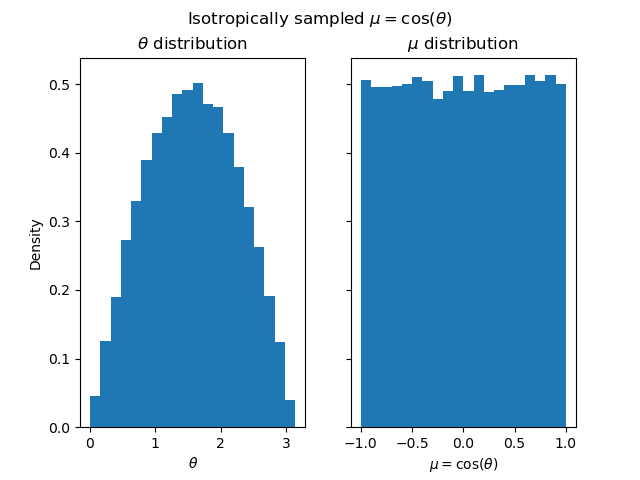

In [7]:
Nbsamples = 50000

mu2 = np.random.uniform(low=-1, high=1, size = Nbsamples)
theta = np.arccos(mu2)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle(r'Isotropically sampled $\mu = \cos(\theta)$')

ax1.hist(theta, bins = 20, density=True)
ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel('Density')
ax1.set_title(r'$\theta$ distribution')

ax2.hist(mu2, bins = 20, density=True)
ax2.set_xlabel(r'$\mu = \cos(\theta)$')
ax2.set_title(r'$\mu$ distribution')

plt.show()